#  Parkinson's Disease Prediction

## 1️⃣ Load Libraries & Data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier

DATA_FILE = 'parkinsons.data'
df = pd.read_csv(DATA_FILE)
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


## 2️⃣ Exploratory Data Analysis (EDA)

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


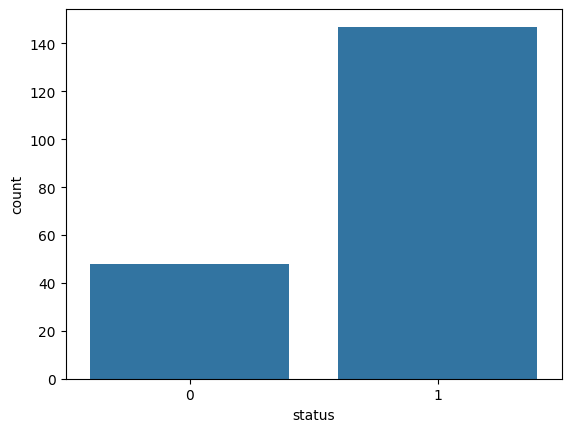

In [2]:
print(df.isnull().sum())
df.describe()
sns.countplot(x='status', data=df)
plt.show()

## 3️⃣ Data Preprocessing & Pipeline Setup

In [3]:
X = df.drop(['status','name'], axis=1, errors='ignore')
y = df['status']

pipeline = Pipeline([
    ('power', PowerTransformer()),
    ('scaler', MinMaxScaler((-1,1))),
    ('model', XGBClassifier(random_state=42, eval_metric='logloss'))
])

## 4️⃣ Hyperparameter Tuning with Cross-Validation

In [4]:
param_grid = {
    'model__max_depth': [3, 5, 7,11],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [50, 100],
    'model__subsample': [0.8, 1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Split data into training and testing sets first
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTETomek only to the training data
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_smote, y_train_smote)

grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

# Fit GridSearchCV on the resampled training data
grid.fit(X_train_resampled, y_train_resampled)

print('Best Params:', grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__subsample': 0.8}


## 5️⃣ Evaluation on Train/Test Split

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.93      0.98      0.96        44

    accuracy                           0.93        59
   macro avg       0.93      0.89      0.91        59
weighted avg       0.93      0.93      0.93        59



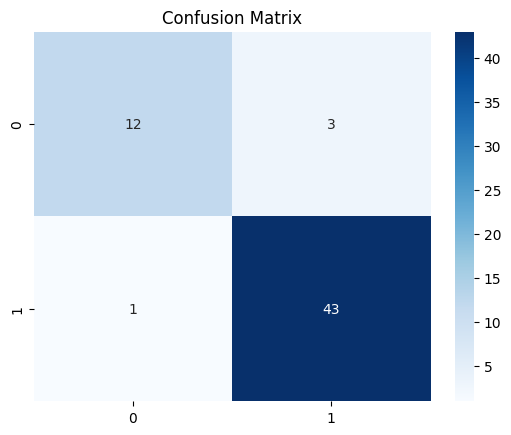

ROC AUC: 0.9121212121212121


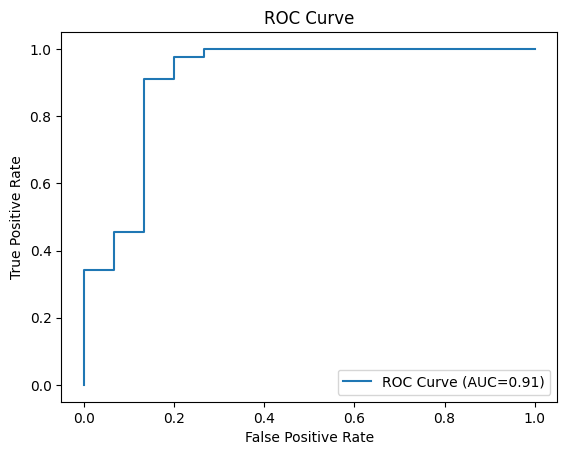

In [5]:
# Split data into training and testing sets first (needed for SMOTETomek)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTETomek only to the training data
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_smote, y_train_smote)


# Use the already split X_test_smote and y_test_smote
best_model = grid.best_estimator_
best_model.fit(X_train_resampled, y_train_resampled) # Fit the best model on the resampled training data

y_pred = best_model.predict(X_test_smote)
y_prob = best_model.predict_proba(X_test_smote)[:,1]

print(classification_report(y_test_smote, y_pred))

cm = confusion_matrix(y_test_smote, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

roc_auc = roc_auc_score(y_test_smote, y_prob)
print('ROC AUC:', roc_auc)

fpr, tpr, _ = roc_curve(y_test_smote, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## ✅ Conclusion
- Used pipeline: PowerTransformer + SMOTE + Scaling + XGBoost
- Cross-validated tuning and final evaluation
